## Initial Setup

### Install Packages

In [334]:
# !pip install numpy
# !pip install opencv-python
# !pip install pillow
# !pip install matplotlib
# !pip install tqdm
# !pip install scikit-learn
# !pip install torch torchvision
# !pip install ultralytics



In [335]:
# Core packages
import os
import shutil
import json
import zipfile
import xml.etree.ElementTree as ET
from pathlib import Path

# Math and array handling
import numpy as np
from sklearn.model_selection import train_test_split

# Image and visualization
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Progress bar
from tqdm.auto import tqdm

# Deep Learning Frameworks
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.models.segmentation as segmentation
import torchvision.transforms as transforms

# Object Detection and Segmentation
from ultralytics import YOLO

from torch.utils.data import DataLoader
import gc

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Automatically use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

import random





### Download Datasets

In [336]:
def download_and_extract_from_gdrive(gdrive_url, extract_to="extracted"):
    # Convert shared drive URL to direct download URL
    file_id = gdrive_url.split("/d/")[1].split("/")[0]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Create output folder
    os.makedirs(extract_to, exist_ok=True)

    zip_path = os.path.join(extract_to, "downloaded.zip")

    print("[INFO] Downloading ZIP from Google Drive...")
    gdown.download(download_url, zip_path, quiet=False)

    print("[INFO] Extracting ZIP...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Optionally, remove the ZIP file after extraction
    os.remove(zip_path)

    print(f"[DONE] Extracted files to: {extract_to}")



### Convert downloaded Dataset into yolo format

In [337]:
# ----------------------------
# Parse polygon and convert to YOLO bbox
# ----------------------------
def parse_yolo_style_bbox_from_xml(xml_path, class_id_to_name):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bboxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name in [value[0] for value in class_id_to_name.values()]:
            polygon = obj.find('polygon')
            if polygon is not None:
                points = polygon.findall('pt')
                coords = [(float(pt.find('x').text), float(pt.find('y').text)) for pt in points]
                x_min = min(coord[0] for coord in coords)
                y_min = min(coord[1] for coord in coords)
                x_max = max(coord[0] for coord in coords)
                y_max = max(coord[1] for coord in coords)
                bboxes.append(((x_min, y_min), (x_max, y_max), class_name))
    return bboxes


# ----------------------------
# Save YOLO-format txt
# ----------------------------
def save_yolo_format(image_id, bboxes, image_width, image_height, output_path, class_id_to_name):
    with open(output_path, 'w') as f:
        for (x_min, y_min), (x_max, y_max), class_name in bboxes:
            class_id = next(cid for cid, (name, _) in class_id_to_name.items() if name == class_name)
            x_center = (x_min + x_max) / 2 / image_width
            y_center = (y_min + y_max) / 2 / image_height
            width = (x_max - x_min) / image_width
            height = (y_max - y_min) / image_height
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


# ----------------------------
# Convert dataset (YOLO only)
# ----------------------------
def convert_fulldataset_yolo_only(dataset_path, output_dir, class_id_to_name):
    image_ids = [img.split('.')[0] for img in os.listdir(f"{dataset_path}/images") if img.endswith(".jpg")]

    os.makedirs(f"{output_dir}/images", exist_ok=True)
    os.makedirs(f"{output_dir}/labels", exist_ok=True)

    for image_id in tqdm(image_ids, desc="Converting to YOLO"):
        img_path = f"{dataset_path}/images/{image_id}.jpg"
        bbox_xml_path = f"{dataset_path}/gt/bounding_box/label_me_xml/{image_id}.xml"
        semantic_xml_path = f"{dataset_path}/gt/semantic/label_me_xml/{image_id}.xml"

        if not os.path.exists(img_path):
            print(f"[WARNING] Image not found: {img_path}, skipping...")
            continue

        try:
            bboxes1 = parse_yolo_style_bbox_from_xml(bbox_xml_path, class_id_to_name)
            bboxes2 = parse_yolo_style_bbox_from_xml(semantic_xml_path, class_id_to_name)
            all_bboxes = bboxes1 + bboxes2
        except Exception as e:
            print(f"[WARNING] Skipping image {image_id} due to parse error: {e}")
            continue

        try:
            image = Image.open(img_path)
            image_np = np.array(image)
        except Exception as e:
            print(f"[WARNING] Could not load image {image_id}: {e}")
            continue

        # Save image
        image.save(f"{output_dir}/images/{image_id}.jpg")

        # Save YOLO labels
        yolo_annotation_path = f"{output_dir}/labels/{image_id}.txt"
        save_yolo_format(image_id, all_bboxes, image_np.shape[1], image_np.shape[0], yolo_annotation_path, class_id_to_name)

    print("✅ YOLO-format annotation conversion complete!")

### Visualizing images with bounding boxes

In [338]:

# Function to load YOLO bounding box annotations
def load_yolo_annotations(anno_file):
    with open(anno_file, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to visualize image and bounding boxes
def visualize_data(image_id, class_id_to_name, image_dir, annotations_dir):
    img_path = os.path.join(image_dir, f"{image_id}.jpg")
    annotation_path = os.path.join(annotations_dir, f"{image_id}.txt")

    if not os.path.exists(img_path) or not os.path.exists(annotation_path):
        print(f"[WARNING] Missing files for {image_id}, skipping...")
        return

    # Load image
    image = Image.open(img_path)
    image = np.array(image)

    # Load annotations
    boxes = load_yolo_annotations(annotation_path)

    # Draw boxes
    image_with_boxes = image.copy()
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        class_name, color = class_id_to_name[int(class_id)]

        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        x_max = int((x_center + width / 2) * image.shape[1])
        y_max = int((y_center + height / 2) * image.shape[0])

        # Change the line width of the rectangle (increase from 4 to any desired thickness)
        rectangle_thickness = 15  # Adjust line thickness here
        cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), color, rectangle_thickness)

        # Change font size and color of the class name (increase font scale and adjust color)
        font_scale = 5  # Larger font size
        font_thickness = 5  # Thickness of the text
        text_color = (255, 0, 0)  # Set text color to white (change as desired)
        cv2.putText(image_with_boxes, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(image_with_boxes)
    plt.title(f"Image ID: {image_id}")
    
    # Add class legend
    legend_handles = []
    for class_id, (class_name, class_rgb) in class_id_to_name.items():
        legend_handles.append(mpatches.Patch(color=np.array(class_rgb)/255.0, label=f"{class_name} ({class_id})"))
    plt.legend(handles=legend_handles, loc='upper right', fontsize=10)
    plt.axis('off')
    plt.show()


### Convert into train set and val set 

In [339]:
import os
import shutil
import random
from tqdm import tqdm

def move_files(file_list, 
               source_image_dir, 
               source_annotation_dir,
               target_image_dir, 
               target_annotation_dir):
    
    os.makedirs(target_image_dir, exist_ok=True)
    os.makedirs(target_annotation_dir, exist_ok=True)

    for image_id in tqdm(file_list, desc=f"Moving to {os.path.basename(os.path.dirname(target_image_dir))}"):
        image_path = os.path.join(source_image_dir, f"{image_id}.jpg")
        annotation_path = os.path.join(source_annotation_dir, f"{image_id}.txt")

        target_image_path = os.path.join(target_image_dir, f"{image_id}.jpg")
        target_annotation_path = os.path.join(target_annotation_dir, f"{image_id}.txt")

        if os.path.exists(image_path):
            shutil.copy(image_path, target_image_path)
        else:
            print(f"[Warning] Missing image: {image_path}")

        if os.path.exists(annotation_path):
            shutil.copy(annotation_path, target_annotation_path)
        else:
            print(f"[Warning] Missing annotation: {annotation_path}")

def split_and_move_dataset(source_base_dir="./datasets/new_dataset_yolo",
                           target_base_dir="./datasets/new_dataset_yolo_split",
                           split_ratio=0.8,
                           seed=42):
    random.seed(seed)

    image_dir = os.path.join(source_base_dir, "images")
    label_dir = os.path.join(source_base_dir, "labels")

    image_ids = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(".jpg")]
    random.shuffle(image_ids)

    split_idx = int(len(image_ids) * split_ratio)
    train_ids = image_ids[:split_idx]
    val_ids = image_ids[split_idx:]

    # Train
    move_files(train_ids,
               source_image_dir=image_dir,
               source_annotation_dir=label_dir,
               target_image_dir=os.path.join(target_base_dir, "train/images"),
               target_annotation_dir=os.path.join(target_base_dir, "train/labels"))

    # Val
    move_files(val_ids,
               source_image_dir=image_dir,
               source_annotation_dir=label_dir,
               target_image_dir=os.path.join(target_base_dir, "val/images"),
               target_annotation_dir=os.path.join(target_base_dir, "val/labels"))

    print(f"\n[✓] Dataset split completed: {len(train_ids)} train / {len(val_ids)} val samples")


### Normalize labels

In [340]:
import os
from PIL import Image

def normalize_label_file(label_file, img_width, img_height):
    """
    Normalize the label coordinates in a label file to ensure they are within [0, 1] range.
    """
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    with open(label_file, 'w') as f:
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            # Normalize coordinates to ensure they are within the range [0, 1]
            x_center = min(1.0, max(0.0, x_center))
            y_center = min(1.0, max(0.0, y_center))
            width = min(1.0, max(0.0, width))
            height = min(1.0, max(0.0, height))

            # Write normalized values back to file
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")


def get_image_size(img_path):
    """
    Get the width and height of the image to normalize the coordinates properly.
    """
    with Image.open(img_path) as img:
        return img.size  # returns (width, height)


def normalize_all_labels(labels_dir, img_dir):
    """
    Normalize all label files in the specified directory.
    """
    for label_file in tqdm(os.listdir(labels_dir)):
       
        if label_file.endswith('.txt'):  # Process only label files
            label_path = os.path.join(labels_dir, label_file)
            img_path = os.path.join(img_dir, label_file.replace('.txt', '.jpg'))  # Assuming JPG images
            if os.path.exists(img_path):
                # Get image dimensions to normalize the labels
                img_width, img_height = get_image_size(img_path)
                # print(f"Normalizing {label_file}...")
                normalize_label_file(label_path, img_width, img_height)
            else:
                print(f"Warning: Image for label {label_file} not found!")
    print("Normalize Complete")



### Training 

In [341]:
def train_yolo(data_yaml="uavdt_yolo.yaml", epochs=40, imgsz=640, batch=32, name="yolov8-uavdt"):
    model = YOLO("yolov8n.pt")
    model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        show=True,
        name=name,
        project="runs_yolo/train"
    )

### Finding best model path

In [342]:
def find_best_pt(base_dir='runs_yolo/'):
    best_paths = list(Path(base_dir).rglob('best.pt'))
    if not best_paths:
        raise FileNotFoundError("No 'best.pt' file found in the 'runs/' directory.")
    
    # Optionally, sort by latest modified time
    best_paths.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    
    print(f"✅ Found best.pt at: {best_paths[0]}")
    return str(best_paths[0])


### Prediciton on val images

In [343]:
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from ultralytics import YOLO

# -------- Your custom class-color-name mapping -------- #
class_id_to_name = {
    0: ('road', [28, 42, 168]),
    1: ('pool', [0, 50, 89]),
    2: ('vegetation', [107, 142, 35]),
    3: ('roof', [70, 70, 70]),
    4: ('wall', [102, 102, 156]),
    5: ('window', [254, 228, 12]),
    6: ('person', [255, 22, 96]),
    7: ('dog', [102, 51, 0]),
    8: ('car', [9, 143, 150]),
    9: ('bicycle', [119, 11, 32]),
    10: ('tree', [51, 51, 0]),
}

# -------- Load YOLO Model -------- #
def load_yolo_model(weight_path: str):
    return YOLO(weight_path)

# -------- Run YOLO Prediction -------- #
def run_yolo(model, image: Image.Image):
    temp_path = "temp_yolo.jpg"
    image.save(temp_path)
    result = model.predict(source=temp_path, conf=0.3, save=False, verbose=False)[0]
    os.remove(temp_path)
    return result

# -------- Draw Bounding Boxes using fixed class colors -------- #
def draw_yolo_boxes(draw: ImageDraw.ImageDraw, result):
    boxes = result.boxes
    for i in range(len(boxes)):
        box = boxes.xyxy[i].cpu().numpy()
        cls_id = int(boxes.cls[i])
        conf = float(boxes.conf[i])
        name, color = class_id_to_name.get(cls_id, (f"id_{cls_id}", [255, 255, 255]))
        label = f"{name} {conf:.2f}"

        draw.rectangle(box.tolist(), outline=tuple(color), width=2)
        draw.text((box[0], box[1]), label, fill=tuple(color))

# -------- Create Legend using fixed class colors -------- #
def generate_yolo_legend(result):
    legend_img = Image.new("RGB", (256, 300), (0, 0, 0))
    draw = ImageDraw.Draw(legend_img)
    class_ids = result.boxes.cls.cpu().numpy().astype(int)
    unique_ids = np.unique(class_ids)
    for idx, cls_id in enumerate(unique_ids):
        name, color = class_id_to_name.get(cls_id, (f"id_{cls_id}", [255, 255, 255]))
        draw.rectangle([10, 10 + idx * 25, 30, 30 + idx * 25], fill=tuple(color))
        draw.text((40, 10 + idx * 25), f"{cls_id}: {name}", fill=(255, 255, 255))
    return legend_img

# -------- Visualize YOLO Predictions -------- #
def visualize_yolo_on_val_images(val_image_dir, yolo_model, max_images=10):
    image_files = sorted([f for f in os.listdir(val_image_dir) if f.endswith(".jpg")])
    
    for i, image_file in enumerate(image_files[:max_images]):
        image_path = os.path.join(val_image_dir, image_file)
        original_image = Image.open(image_path).convert("RGB").resize((256, 256))

        # Run YOLO
        yolo_result = run_yolo(yolo_model, original_image)

        # Draw bounding boxes
        yolo_image = original_image.copy()
        draw = ImageDraw.Draw(yolo_image)
        draw_yolo_boxes(draw, yolo_result)

        # Create legend image
        yolo_legend_img = generate_yolo_legend(yolo_result)

        # Plot results
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(yolo_image)
        axs[0].set_title(f"YOLO Detection: {image_file}")
        axs[0].axis("off")

        axs[1].imshow(yolo_legend_img)
        axs[1].set_title("YOLO Class Legend")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()


### Predcitions on videos

In [344]:
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO


output_base = './video_outputs'

# ================== OUTPUT FOLDERS ==================
img_dir = os.path.join(output_base, 'images')
label_dir = os.path.join(output_base, 'labels')
video_output_path = os.path.join(output_base, 'output_video.mp4')  # <-- Defined here

os.makedirs(img_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

# ================== IMAGE TRANSFORM ==================
def get_transform():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

# ================== PROCESS FRAME ==================
def process_frame(frame, yolo_model, w, h, class_id_to_name):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)

    # === YOLO Detection ===
    results = yolo_model(frame)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy()

    # Draw bounding boxes with corresponding colors and class names
    for box, cls_id in zip(boxes, class_ids):
        x1, y1, x2, y2 = map(int, box)
        
        # Get the class name and corresponding color from the dictionary
        class_name, color = class_id_to_name[int(cls_id)]
        
        # Draw the bounding box with the class color
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        
        # Put class name above the bounding box
        cv2.putText(frame, class_name, (x1, max(y1 - 10, 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

    return frame_rgb, boxes, class_ids

# ================== SAVE OUTPUTS ==================
def save_outputs(frame_rgb, boxes, class_ids, frame_count, w, h, img_dir, label_dir, class_id_to_name):
    # Save original frame
    out_img = os.path.join(img_dir, f'frame_{frame_count:04d}.jpg')
    out_label = os.path.join(label_dir, f'frame_{frame_count:04d}.txt')

    # Save original frame
    cv2.imwrite(out_img, frame_rgb[..., ::-1])  # RGB -> BGR

    # Save YOLO labels
    with open(out_label, 'w') as f:
        for box, cls_id in zip(boxes, class_ids):
            x1, y1, x2, y2 = box
            w_box = x2 - x1
            h_box = y2 - y1
            cx = x1 + w_box / 2
            cy = y1 + h_box / 2
            cx /= w
            cy /= h
            w_box /= w
            h_box /= h
            f.write(f"{int(cls_id)} {cx:.6f} {cy:.6f} {w_box:.6f} {h_box:.6f}  # {class_id_to_name[int(cls_id)][0]}\n")

# ================== VIDEO SETUP ==================
def setup_video_capture(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    return cap, total_frames, fps, w, h, fourcc

# ================== MAIN VIDEO PROCESSING ==================
def process_video(video_path, yolo_weights_path, class_id_to_name, max_frames=None):
    yolo_model = YOLO(yolo_weights_path)
    transform = get_transform()
    
    cap, total_frames, fps, w, h, fourcc = setup_video_capture(video_path)
    video_writer = cv2.VideoWriter(video_output_path, fourcc, fps, (w, h))
    
    frame_count = 0
    pbar = tqdm(total=max_frames if max_frames else total_frames, desc="Processing", leave=False)

    while True:
        ret, frame = cap.read()
        if not ret or (max_frames is not None and frame_count >= max_frames):
            break

        frame_rgb, boxes, class_ids = process_frame(frame, yolo_model, w, h, class_id_to_name)
        save_outputs(frame_rgb, boxes, class_ids, frame_count, w, h, img_dir, label_dir, class_id_to_name)

        # Blending frame with bounding boxes
        video_writer.write(frame)

        frame_count += 1
        pbar.update(1)

    cap.release()
    video_writer.release()
    pbar.close()

    print(f"\nDone! Processed {frame_count} frames.")

### Print Metrics

### Retrain and Quantization

## Full Pipeline

### Downaload and Convert Dataset

In [345]:
# # Class ID to name mapping with RGB values
class_id_to_name = {
    0: ('road', [28, 42, 168]),
    1: ('pool', [0, 50, 89]),
    2: ('vegetation', [107, 142, 35]),
    3: ('roof', [70, 70, 70]),
    4: ('wall', [102, 102, 156]),
    5: ('window', [254, 228, 12]),
    6: ('person', [255, 22, 96]),
    7: ('dog', [102, 51, 0]),
    8: ('car', [9, 143, 150]),
    9: ('bicycle', [119, 11, 32]),
    10: ('tree', [51, 51, 0]),
}



# Downlaod the datasets

# gdrive_url = "https://drive.google.com/file/d/1UppumYqYOi-kto6BWPfFxwJK2Eph46oY/view?usp=sharing"
# download_and_extract_from_gdrive(gdrive_url, extract_to="datasets")

# # Path to the dataset
# dataset_path = "./datasets/semantic_drone_dataset/training_set"
# output_dir = "./datasets/new_dataset_yolo"

# convert_fulldataset_yolo_only(dataset_path, output_dir, class_id_to_name)



In [346]:
# dataset_path = "./datasets/new_dataset_yolo"
# image_dir = os.path.join(dataset_path, "images")
# annotations_dir = os.path.join(dataset_path, "labels")


# # Visualize 10 random images
# image_ids = [f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.jpg')]
# random_image_ids = random.sample(image_ids, min(10, len(image_ids)))

# for image_id in random_image_ids:
#     visualize_data(image_id, class_id_to_name, image_dir, annotations_dir)



In [347]:
# # Set your paths
# dataset_path = "./datasets/new_dataset_yolo"
# image_dir = os.path.join(dataset_path, "images")
# annotations_dir = os.path.join(dataset_path, "labels")

# normalize_all_labels(annotations_dir, image_dir)

In [348]:
# Run the split
# split_and_move_dataset()

In [349]:
# print("[+] Training Start")

# # Train YOLOv8
# train_yolo(data_yaml="uavdt_yolo.yaml",  epochs=2, imgsz=640, batch=32, name="yolov8-uavdt")


✅ Found best.pt at: runs_yolo\train\yolov8-uavdt\weights\best.pt


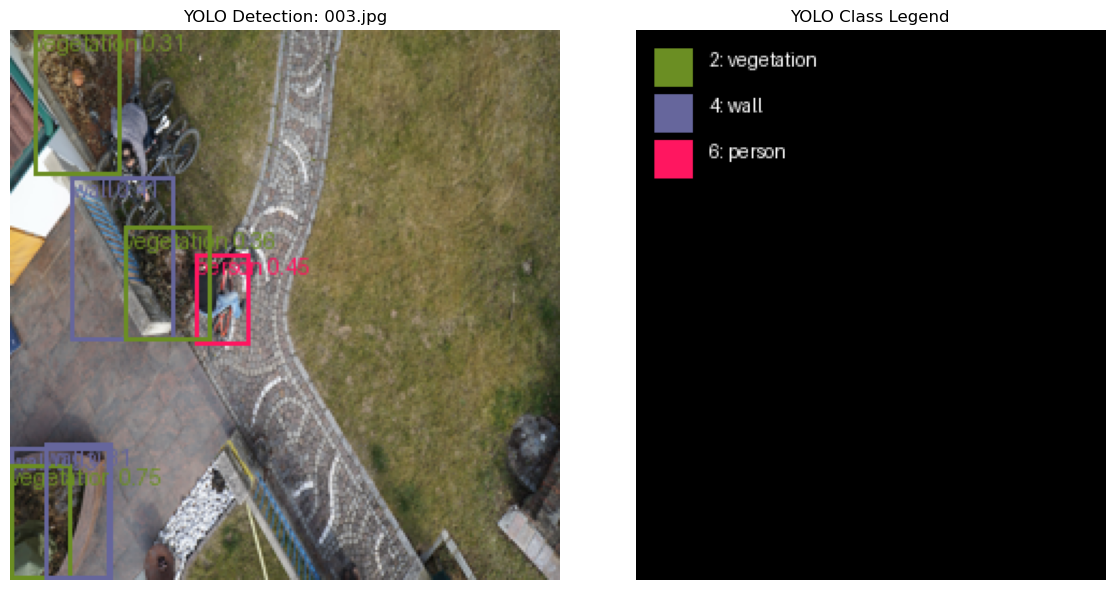

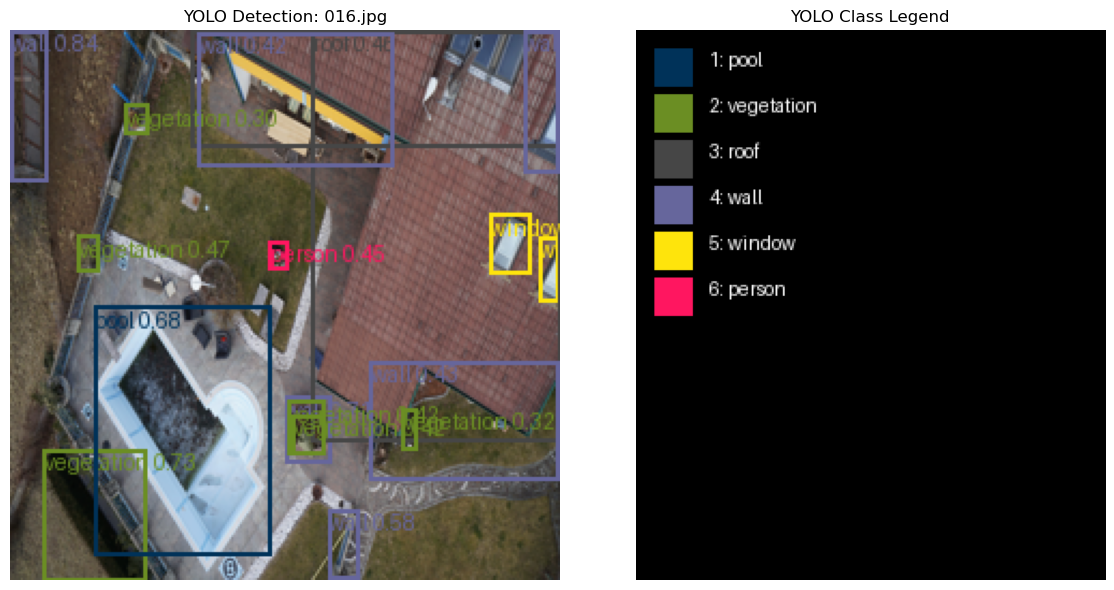

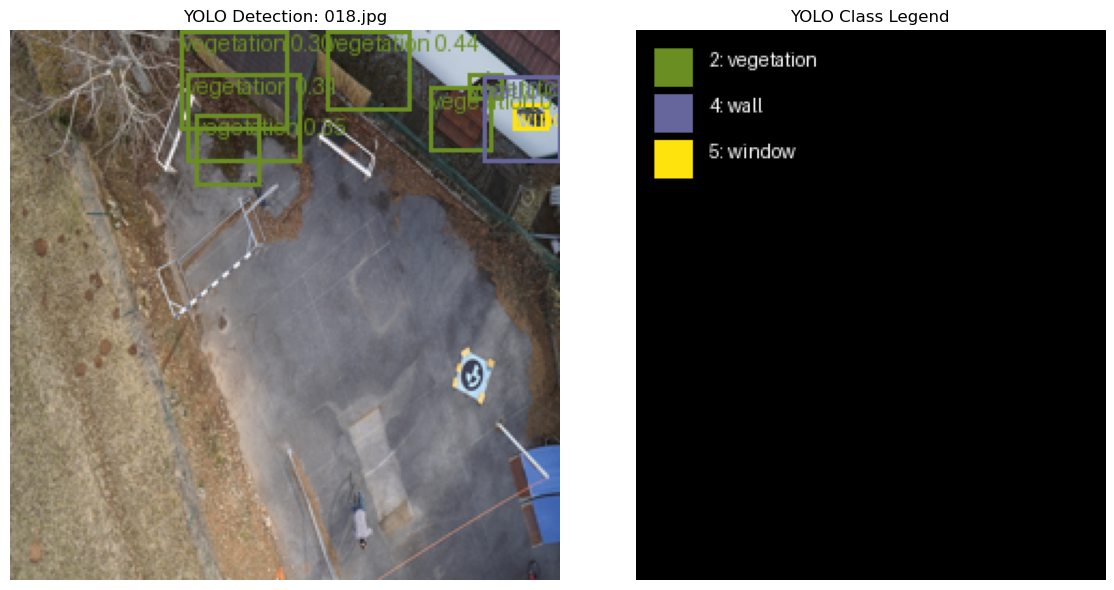

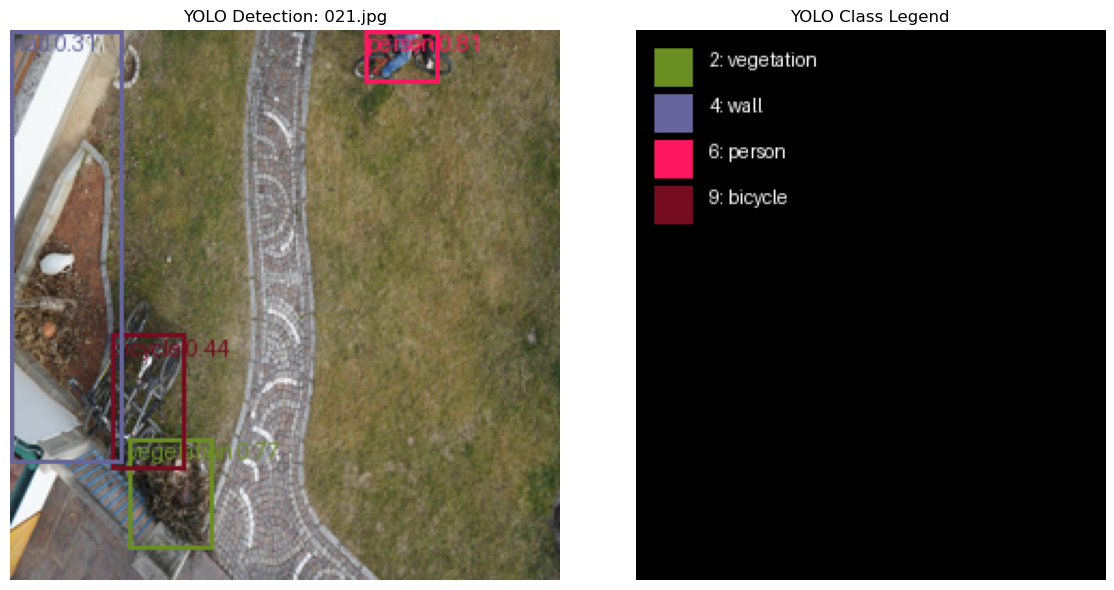

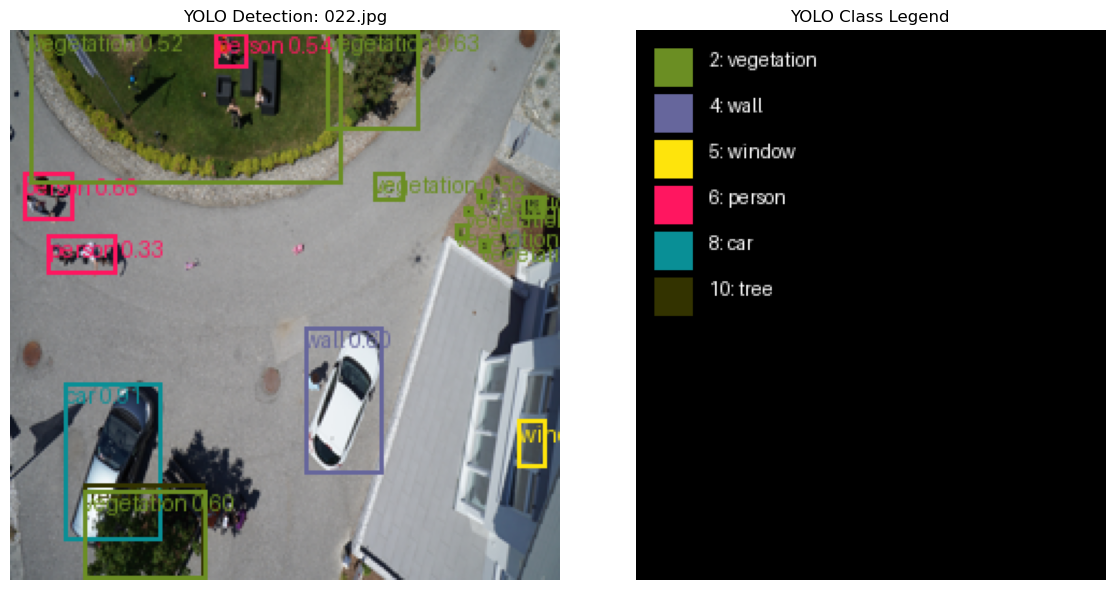

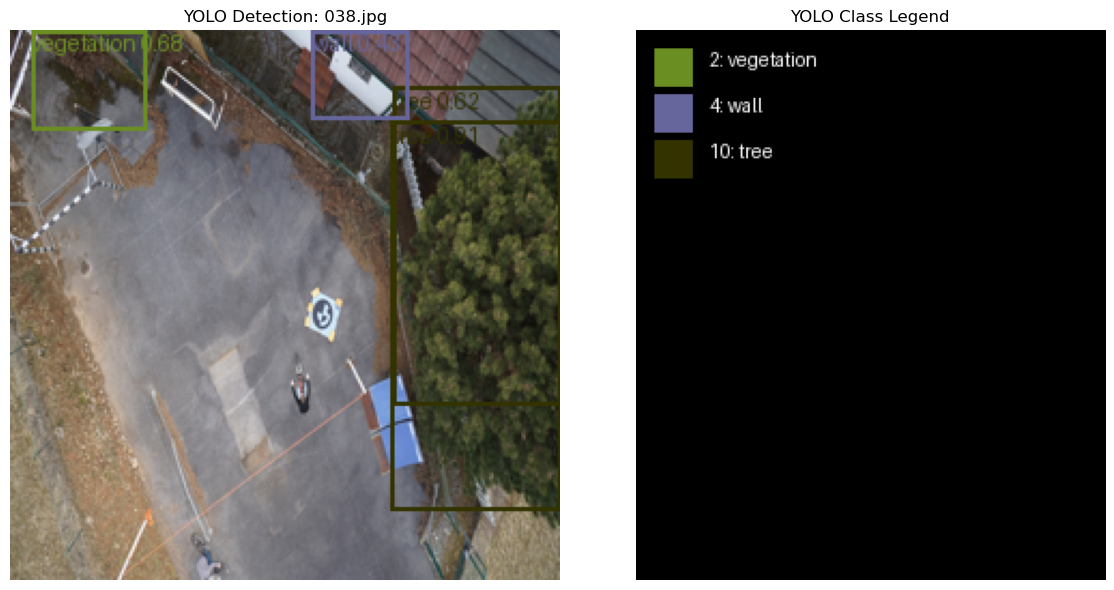

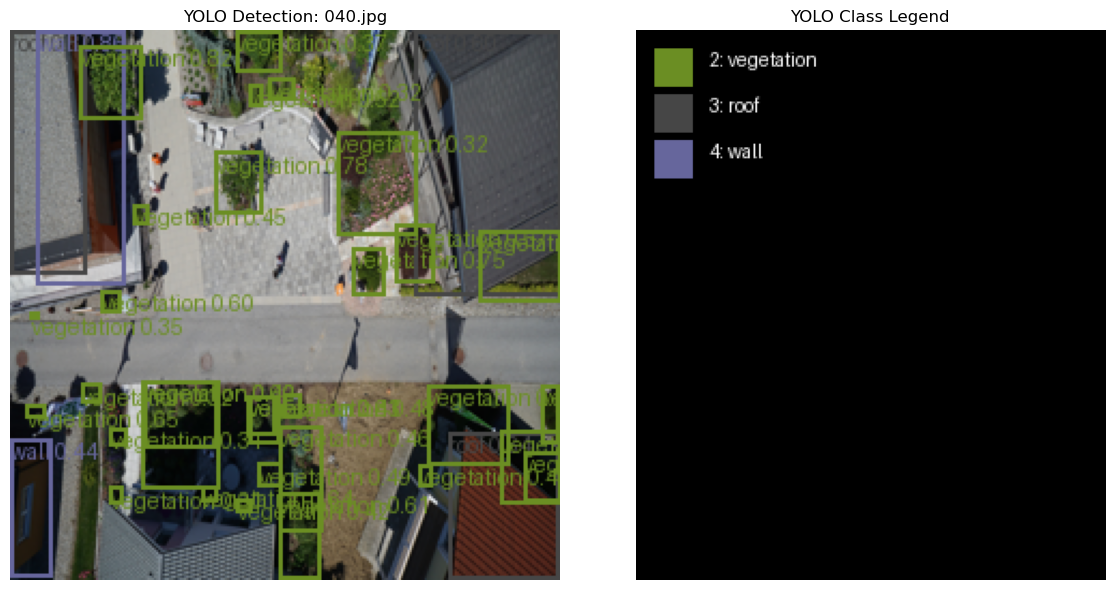

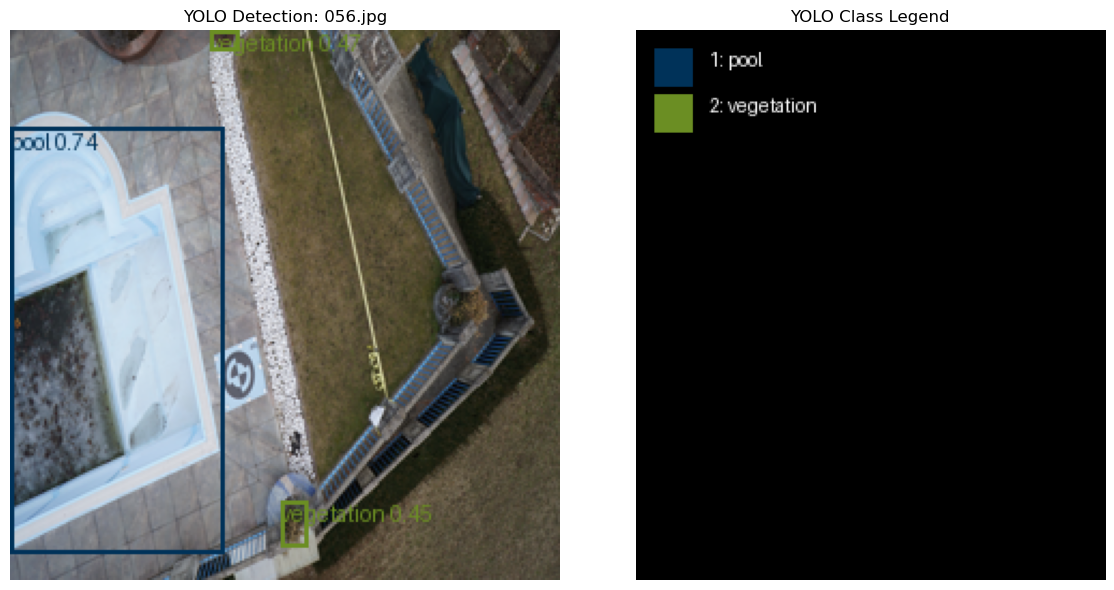

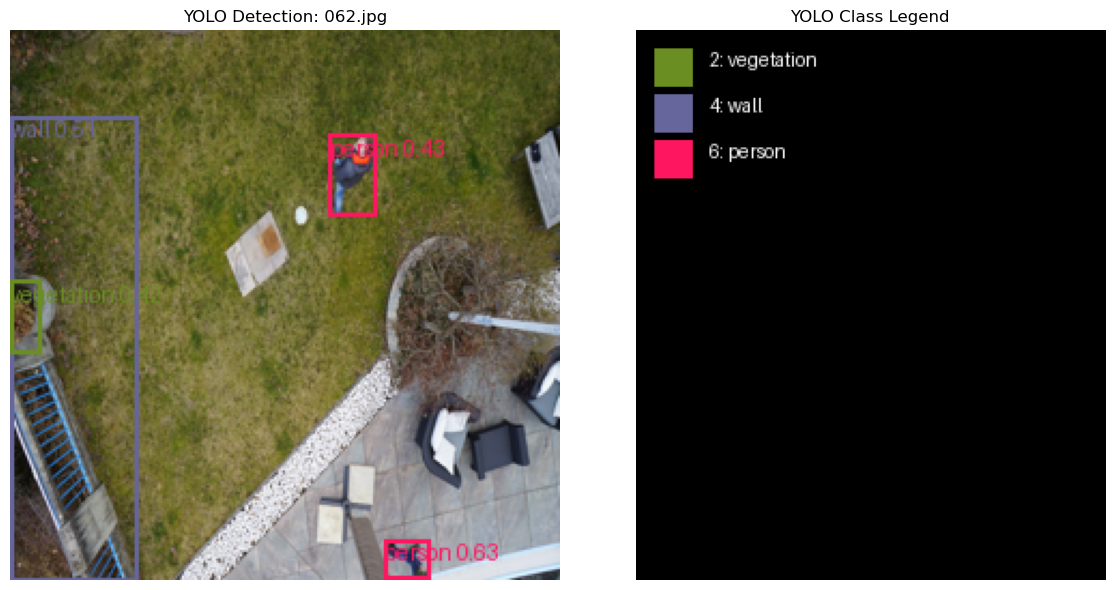

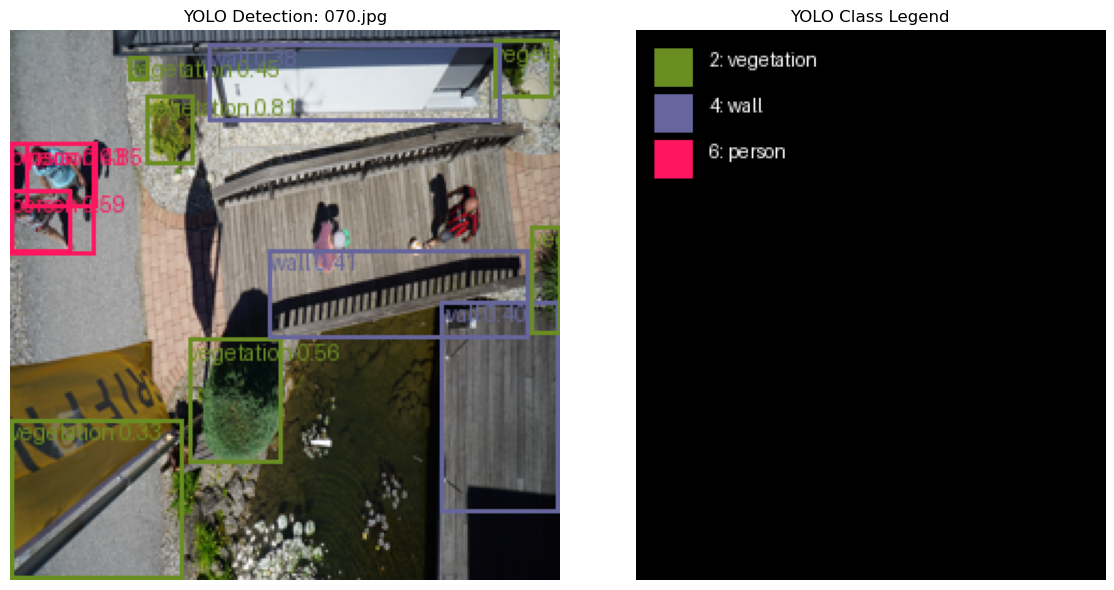

In [350]:
# Load the model
best_pt_path = find_best_pt()

val_image_dir = "./datasets/new_dataset_yolo_split/val/images"  # <<-- make sure this path exists
    
yolo_model = load_yolo_model(best_pt_path)
visualize_yolo_on_val_images(val_image_dir, yolo_model, max_images=10)  # Show only 10 images


In [351]:
# ================== CONFIG ==================
video_path = './video.mp4'
max_frames = None  # Set to None for full video

yolo_weights_path = best_pt_path  # <<-- change this
process_video(video_path, yolo_weights_path, class_id_to_name, max_frames=max_frames)  # Show only 10 frames



Processing:   0%|          | 0/176 [00:00<?, ?it/s]


0: 384x640 3 vegetations, 4 cars, 35.2ms
Speed: 1.3ms preprocess, 35.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing:   1%|          | 1/176 [00:00<00:20,  8.73it/s]


0: 384x640 5 vegetations, 4 cars, 42.5ms
Speed: 1.6ms preprocess, 42.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 3 cars, 40.3ms
Speed: 1.2ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:   2%|▏         | 3/176 [00:00<00:12, 13.94it/s]


0: 384x640 2 vegetations, 1 wall, 4 cars, 39.1ms
Speed: 2.1ms preprocess, 39.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 vegetations, 4 cars, 38.3ms
Speed: 2.2ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:   3%|▎         | 5/176 [00:00<00:10, 15.83it/s]


0: 384x640 3 vegetations, 2 walls, 1 person, 3 cars, 38.0ms
Speed: 1.8ms preprocess, 38.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 3 cars, 35.9ms
Speed: 1.3ms preprocess, 35.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:   4%|▍         | 7/176 [00:00<00:09, 17.04it/s]


0: 384x640 3 vegetations, 6 walls, 1 person, 2 cars, 37.5ms
Speed: 1.4ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 1 person, 4 cars, 38.4ms
Speed: 1.7ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:   5%|▌         | 9/176 [00:00<00:09, 17.61it/s]


0: 384x640 4 vegetations, 3 walls, 2 persons, 3 cars, 38.4ms
Speed: 1.6ms preprocess, 38.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 3 walls, 1 car, 1 bicycle, 35.4ms
Speed: 1.6ms preprocess, 35.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:   6%|▋         | 11/176 [00:00<00:09, 18.03it/s]


0: 384x640 4 vegetations, 4 walls, 1 person, 3 cars, 34.8ms
Speed: 1.6ms preprocess, 34.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 3 walls, 2 persons, 3 cars, 36.7ms
Speed: 1.5ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 1 person, 3 cars, 35.0ms
Speed: 1.6ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:   8%|▊         | 14/176 [00:00<00:08, 18.74it/s]


0: 384x640 2 vegetations, 2 walls, 1 person, 3 cars, 35.7ms
Speed: 1.4ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 2 persons, 3 cars, 39.0ms
Speed: 1.8ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:   9%|▉         | 16/176 [00:00<00:08, 18.86it/s]


0: 384x640 4 vegetations, 1 wall, 2 persons, 3 cars, 39.2ms
Speed: 1.7ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 1 wall, 1 person, 3 cars, 1 bicycle, 36.4ms
Speed: 1.4ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  10%|█         | 18/176 [00:01<00:08, 18.81it/s]


0: 384x640 4 vegetations, 1 wall, 3 persons, 4 cars, 1 bicycle, 36.0ms
Speed: 1.4ms preprocess, 36.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 3 cars, 1 bicycle, 31.0ms
Speed: 1.3ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 3 cars, 1 bicycle, 36.0ms
Speed: 1.5ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  12%|█▏        | 21/176 [00:01<00:08, 19.26it/s]


0: 384x640 3 vegetations, 1 wall, 1 person, 3 cars, 37.2ms
Speed: 1.8ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 1 wall, 1 person, 4 cars, 38.6ms
Speed: 1.3ms preprocess, 38.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  13%|█▎        | 23/176 [00:01<00:08, 19.10it/s]


0: 384x640 3 vegetations, 1 wall, 1 person, 4 cars, 35.6ms
Speed: 1.6ms preprocess, 35.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 1 person, 4 cars, 36.6ms
Speed: 1.3ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  14%|█▍        | 25/176 [00:01<00:07, 19.23it/s]


0: 384x640 2 vegetations, 2 walls, 1 person, 4 cars, 36.5ms
Speed: 1.6ms preprocess, 36.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 1 person, 3 cars, 34.6ms
Speed: 1.8ms preprocess, 34.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 2 persons, 3 cars, 37.1ms
Speed: 1.4ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  16%|█▌        | 28/176 [00:01<00:07, 19.33it/s]


0: 384x640 3 vegetations, 1 wall, 3 persons, 3 cars, 33.5ms
Speed: 1.6ms preprocess, 33.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 1 person, 3 cars, 43.2ms
Speed: 1.3ms preprocess, 43.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  17%|█▋        | 30/176 [00:01<00:07, 19.03it/s]


0: 384x640 3 vegetations, 1 wall, 1 person, 3 cars, 44.7ms
Speed: 2.5ms preprocess, 44.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 3 cars, 33.9ms
Speed: 1.3ms preprocess, 33.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  18%|█▊        | 32/176 [00:01<00:07, 18.77it/s]


0: 384x640 3 vegetations, 1 wall, 3 cars, 35.1ms
Speed: 1.5ms preprocess, 35.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 1 person, 2 cars, 34.3ms
Speed: 1.6ms preprocess, 34.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 1 person, 3 cars, 34.8ms
Speed: 1.3ms preprocess, 34.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  20%|█▉        | 35/176 [00:01<00:07, 19.30it/s]


0: 384x640 2 vegetations, 2 persons, 3 cars, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 1 wall, 1 person, 2 cars, 35.7ms
Speed: 1.4ms preprocess, 35.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  21%|██        | 37/176 [00:02<00:07, 19.36it/s]


0: 384x640 2 vegetations, 2 walls, 2 cars, 37.4ms
Speed: 1.8ms preprocess, 37.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 vegetations, 2 walls, 2 persons, 2 cars, 39.3ms
Speed: 1.8ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  22%|██▏       | 39/176 [00:02<00:07, 19.18it/s]


0: 384x640 3 vegetations, 1 wall, 2 persons, 4 cars, 36.3ms
Speed: 1.6ms preprocess, 36.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 4 cars, 38.2ms
Speed: 1.4ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  23%|██▎       | 41/176 [00:02<00:07, 19.17it/s]


0: 384x640 1 vegetation, 2 walls, 4 cars, 36.5ms
Speed: 1.6ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 2 walls, 1 person, 4 cars, 39.6ms
Speed: 1.7ms preprocess, 39.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  24%|██▍       | 43/176 [00:02<00:06, 19.17it/s]


0: 384x640 1 vegetation, 1 wall, 1 person, 5 cars, 38.6ms
Speed: 1.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 1 person, 4 cars, 40.3ms
Speed: 1.8ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  26%|██▌       | 45/176 [00:02<00:06, 18.78it/s]


0: 384x640 3 vegetations, 1 wall, 1 person, 4 cars, 33.8ms
Speed: 1.3ms preprocess, 33.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 1 wall, 2 persons, 3 cars, 37.5ms
Speed: 1.3ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  27%|██▋       | 47/176 [00:02<00:06, 18.93it/s]


0: 384x640 3 vegetations, 1 wall, 2 persons, 5 cars, 38.6ms
Speed: 1.5ms preprocess, 38.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 vegetations, 1 wall, 1 person, 8 cars, 36.4ms
Speed: 1.3ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  28%|██▊       | 49/176 [00:02<00:06, 19.02it/s]


0: 384x640 1 vegetation, 2 walls, 1 person, 6 cars, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 6 cars, 37.6ms
Speed: 1.4ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  29%|██▉       | 51/176 [00:02<00:06, 18.85it/s]


0: 384x640 2 vegetations, 1 wall, 7 cars, 37.2ms
Speed: 1.4ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 2 persons, 6 cars, 36.0ms
Speed: 1.4ms preprocess, 36.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  30%|███       | 53/176 [00:02<00:06, 18.85it/s]


0: 384x640 2 vegetations, 1 wall, 6 cars, 36.5ms
Speed: 1.6ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 6 cars, 35.3ms
Speed: 1.4ms preprocess, 35.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  31%|███▏      | 55/176 [00:02<00:06, 18.93it/s]


0: 384x640 3 vegetations, 1 wall, 6 cars, 52.6ms
Speed: 1.9ms preprocess, 52.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 1 wall, 1 person, 5 cars, 44.2ms
Speed: 2.0ms preprocess, 44.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  32%|███▏      | 57/176 [00:03<00:06, 17.44it/s]


0: 384x640 5 vegetations, 1 wall, 2 persons, 5 cars, 63.0ms
Speed: 2.2ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 vegetations, 1 wall, 1 person, 4 cars, 38.2ms
Speed: 1.5ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  34%|███▎      | 59/176 [00:03<00:07, 16.38it/s]


0: 384x640 4 vegetations, 1 wall, 1 person, 4 cars, 37.6ms
Speed: 1.5ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 vegetations, 2 walls, 3 persons, 4 cars, 38.3ms
Speed: 1.2ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  35%|███▍      | 61/176 [00:03<00:06, 16.94it/s]


0: 384x640 2 vegetations, 1 wall, 3 persons, 4 cars, 42.7ms
Speed: 1.7ms preprocess, 42.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 1 person, 4 cars, 37.9ms
Speed: 1.6ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  36%|███▌      | 63/176 [00:03<00:06, 17.21it/s]


0: 384x640 4 vegetations, 1 wall, 1 person, 4 cars, 37.5ms
Speed: 1.5ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 1 person, 4 cars, 37.3ms
Speed: 1.7ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  37%|███▋      | 65/176 [00:03<00:06, 17.66it/s]


0: 384x640 3 vegetations, 2 walls, 5 persons, 5 cars, 36.8ms
Speed: 1.3ms preprocess, 36.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 5 persons, 4 cars, 39.0ms
Speed: 1.5ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  38%|███▊      | 67/176 [00:03<00:06, 17.96it/s]


0: 384x640 2 vegetations, 1 wall, 2 persons, 4 cars, 38.2ms
Speed: 1.7ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 2 walls, 2 persons, 4 cars, 38.9ms
Speed: 1.7ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing:  39%|███▉      | 69/176 [00:03<00:05, 17.96it/s]


0: 384x640 4 vegetations, 1 wall, 2 persons, 4 cars, 36.6ms
Speed: 1.6ms preprocess, 36.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 vegetations, 2 walls, 3 persons, 4 cars, 35.7ms
Speed: 1.3ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  40%|████      | 71/176 [00:03<00:05, 18.42it/s]


0: 384x640 4 vegetations, 1 wall, 3 persons, 3 cars, 36.8ms
Speed: 1.3ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 3 persons, 3 cars, 36.0ms
Speed: 1.7ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  41%|████▏     | 73/176 [00:03<00:05, 18.61it/s]


0: 384x640 3 vegetations, 2 walls, 3 persons, 3 cars, 37.1ms
Speed: 1.6ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 vegetations, 2 walls, 2 persons, 3 cars, 39.7ms
Speed: 1.8ms preprocess, 39.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  43%|████▎     | 75/176 [00:04<00:05, 18.56it/s]


0: 384x640 3 vegetations, 3 walls, 2 persons, 3 cars, 37.2ms
Speed: 1.6ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 vegetations, 2 walls, 4 persons, 3 cars, 35.1ms
Speed: 1.5ms preprocess, 35.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  44%|████▍     | 77/176 [00:04<00:05, 18.91it/s]


0: 384x640 4 vegetations, 4 walls, 3 persons, 4 cars, 36.4ms
Speed: 1.3ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 2 walls, 2 persons, 4 cars, 1 tree, 38.4ms
Speed: 1.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  45%|████▍     | 79/176 [00:04<00:05, 18.82it/s]


0: 384x640 3 vegetations, 2 walls, 2 persons, 4 cars, 39.8ms
Speed: 1.5ms preprocess, 39.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 vegetations, 3 walls, 3 persons, 3 cars, 38.2ms
Speed: 1.3ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  46%|████▌     | 81/176 [00:04<00:05, 18.76it/s]


0: 384x640 4 vegetations, 3 walls, 2 persons, 3 cars, 35.9ms
Speed: 1.3ms preprocess, 35.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 3 walls, 2 persons, 3 cars, 38.0ms
Speed: 1.3ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  47%|████▋     | 83/176 [00:04<00:04, 18.87it/s]


0: 384x640 2 vegetations, 2 walls, 2 persons, 3 cars, 39.0ms
Speed: 1.7ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 vegetations, 2 walls, 4 persons, 4 cars, 69.4ms
Speed: 1.5ms preprocess, 69.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing:  48%|████▊     | 85/176 [00:04<00:05, 17.21it/s]


0: 384x640 4 vegetations, 2 walls, 4 persons, 3 cars, 36.0ms
Speed: 1.9ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 1 wall, 4 persons, 3 cars, 35.1ms
Speed: 1.3ms preprocess, 35.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  49%|████▉     | 87/176 [00:04<00:04, 17.81it/s]


0: 384x640 4 vegetations, 1 wall, 3 persons, 3 cars, 35.7ms
Speed: 1.4ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 3 persons, 3 cars, 35.2ms
Speed: 1.4ms preprocess, 35.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  51%|█████     | 89/176 [00:04<00:04, 18.40it/s]


0: 384x640 1 vegetation, 1 wall, 6 persons, 3 cars, 39.7ms
Speed: 1.3ms preprocess, 39.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 3 walls, 5 persons, 2 cars, 38.7ms
Speed: 2.0ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  52%|█████▏    | 91/176 [00:04<00:04, 18.39it/s]


0: 384x640 2 vegetations, 1 wall, 6 persons, 2 cars, 36.4ms
Speed: 1.4ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 5 persons, 2 cars, 34.1ms
Speed: 1.3ms preprocess, 34.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  53%|█████▎    | 93/176 [00:05<00:04, 18.79it/s]


0: 384x640 2 vegetations, 1 wall, 5 persons, 2 cars, 35.3ms
Speed: 1.5ms preprocess, 35.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 vegetations, 1 wall, 4 persons, 3 cars, 36.0ms
Speed: 1.7ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 1 wall, 4 persons, 4 cars, 40.6ms
Speed: 1.3ms preprocess, 40.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  55%|█████▍    | 96/176 [00:05<00:04, 18.95it/s]


0: 384x640 3 vegetations, 2 walls, 4 persons, 3 cars, 36.9ms
Speed: 1.6ms preprocess, 36.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 6 persons, 4 cars, 38.2ms
Speed: 1.2ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  56%|█████▌    | 98/176 [00:05<00:04, 19.09it/s]


0: 384x640 2 vegetations, 2 walls, 4 persons, 4 cars, 37.5ms
Speed: 1.4ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 2 walls, 2 persons, 3 cars, 34.1ms
Speed: 1.3ms preprocess, 34.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  57%|█████▋    | 100/176 [00:05<00:03, 19.15it/s]


0: 384x640 2 vegetations, 2 walls, 2 persons, 4 cars, 35.1ms
Speed: 1.7ms preprocess, 35.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 3 persons, 3 cars, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  58%|█████▊    | 102/176 [00:05<00:03, 19.00it/s]


0: 384x640 2 vegetations, 3 persons, 3 cars, 39.0ms
Speed: 1.6ms preprocess, 39.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 4 persons, 3 cars, 34.8ms
Speed: 1.5ms preprocess, 34.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  59%|█████▉    | 104/176 [00:05<00:03, 19.22it/s]


0: 384x640 2 vegetations, 1 wall, 4 persons, 3 cars, 37.0ms
Speed: 1.4ms preprocess, 37.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 3 persons, 3 cars, 34.5ms
Speed: 1.2ms preprocess, 34.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  60%|██████    | 106/176 [00:05<00:03, 19.32it/s]


0: 384x640 1 vegetation, 3 persons, 3 cars, 36.7ms
Speed: 1.9ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 4 persons, 3 cars, 38.0ms
Speed: 1.4ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  61%|██████▏   | 108/176 [00:05<00:03, 19.19it/s]


0: 384x640 2 vegetations, 3 persons, 2 cars, 39.4ms
Speed: 1.6ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 3 persons, 2 cars, 35.5ms
Speed: 1.6ms preprocess, 35.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  62%|██████▎   | 110/176 [00:05<00:03, 19.18it/s]


0: 384x640 2 vegetations, 4 persons, 3 cars, 35.5ms
Speed: 1.4ms preprocess, 35.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 4 persons, 2 cars, 35.7ms
Speed: 1.5ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  64%|██████▎   | 112/176 [00:06<00:03, 19.30it/s]


0: 384x640 1 vegetation, 4 persons, 2 cars, 49.0ms
Speed: 1.4ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 4 persons, 2 cars, 43.9ms
Speed: 2.6ms preprocess, 43.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  65%|██████▍   | 114/176 [00:06<00:03, 18.10it/s]


0: 384x640 1 vegetation, 5 persons, 2 cars, 37.5ms
Speed: 1.7ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 4 persons, 2 cars, 35.7ms
Speed: 1.3ms preprocess, 35.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  66%|██████▌   | 116/176 [00:06<00:03, 18.47it/s]


0: 384x640 1 vegetation, 4 persons, 2 cars, 38.4ms
Speed: 1.2ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 3 persons, 2 cars, 35.1ms
Speed: 1.3ms preprocess, 35.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  67%|██████▋   | 118/176 [00:06<00:03, 18.81it/s]


0: 384x640 1 vegetation, 3 persons, 2 cars, 48.3ms
Speed: 1.4ms preprocess, 48.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2 cars, 46.4ms
Speed: 1.5ms preprocess, 46.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  68%|██████▊   | 120/176 [00:06<00:03, 17.64it/s]


0: 384x640 1 vegetation, 6 persons, 2 cars, 43.2ms
Speed: 2.2ms preprocess, 43.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wall, 7 persons, 2 cars, 46.0ms
Speed: 1.8ms preprocess, 46.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  69%|██████▉   | 122/176 [00:06<00:03, 17.25it/s]


0: 384x640 6 persons, 3 cars, 40.3ms
Speed: 1.7ms preprocess, 40.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wall, 6 persons, 2 cars, 40.5ms
Speed: 1.4ms preprocess, 40.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing:  70%|███████   | 124/176 [00:06<00:02, 17.41it/s]


0: 384x640 3 vegetations, 5 persons, 2 cars, 1 tree, 59.8ms
Speed: 1.6ms preprocess, 59.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 6 persons, 2 cars, 1 tree, 36.6ms
Speed: 1.3ms preprocess, 36.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  72%|███████▏  | 126/176 [00:06<00:02, 16.77it/s]


0: 384x640 5 persons, 3 cars, 1 tree, 33.3ms
Speed: 1.2ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 7 persons, 2 cars, 1 tree, 35.9ms
Speed: 1.4ms preprocess, 35.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wall, 9 persons, 2 cars, 41.3ms
Speed: 1.7ms preprocess, 41.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  73%|███████▎  | 129/176 [00:07<00:02, 17.64it/s]


0: 384x640 2 vegetations, 8 persons, 2 cars, 40.7ms
Speed: 1.7ms preprocess, 40.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 7 persons, 2 cars, 36.5ms
Speed: 1.4ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  74%|███████▍  | 131/176 [00:07<00:02, 17.89it/s]


0: 384x640 3 vegetations, 9 persons, 2 cars, 1 tree, 44.1ms
Speed: 1.8ms preprocess, 44.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 7 persons, 3 cars, 41.4ms
Speed: 1.4ms preprocess, 41.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  76%|███████▌  | 133/176 [00:07<00:02, 17.68it/s]


0: 384x640 1 vegetation, 1 wall, 11 persons, 2 cars, 43.2ms
Speed: 1.7ms preprocess, 43.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 7 persons, 2 cars, 1 bicycle, 35.9ms
Speed: 1.7ms preprocess, 35.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  77%|███████▋  | 135/176 [00:07<00:02, 17.80it/s]


0: 384x640 3 vegetations, 7 persons, 2 cars, 1 bicycle, 1 tree, 43.0ms
Speed: 1.6ms preprocess, 43.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 1 wall, 7 persons, 2 cars, 1 tree, 34.9ms
Speed: 1.2ms preprocess, 34.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  78%|███████▊  | 137/176 [00:07<00:02, 17.97it/s]


0: 384x640 2 vegetations, 1 wall, 5 persons, 2 cars, 43.8ms
Speed: 1.4ms preprocess, 43.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 6 persons, 1 car, 34.0ms
Speed: 1.3ms preprocess, 34.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  79%|███████▉  | 139/176 [00:07<00:02, 18.09it/s]


0: 384x640 3 vegetations, 4 persons, 2 cars, 39.6ms
Speed: 1.8ms preprocess, 39.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 4 persons, 2 cars, 33.4ms
Speed: 1.2ms preprocess, 33.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  80%|████████  | 141/176 [00:07<00:01, 18.53it/s]


0: 384x640 2 vegetations, 6 persons, 2 cars, 61.3ms
Speed: 1.7ms preprocess, 61.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 4 persons, 3 cars, 1 bicycle, 37.5ms
Speed: 1.6ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  81%|████████▏ | 143/176 [00:07<00:01, 17.48it/s]


0: 384x640 5 persons, 2 cars, 1 bicycle, 2 trees, 44.6ms
Speed: 1.8ms preprocess, 44.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 1 wall, 5 persons, 1 car, 1 tree, 42.2ms
Speed: 1.9ms preprocess, 42.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  82%|████████▏ | 145/176 [00:07<00:01, 17.13it/s]


0: 384x640 2 vegetations, 8 persons, 2 cars, 1 tree, 41.3ms
Speed: 2.5ms preprocess, 41.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 vegetations, 8 persons, 2 cars, 1 tree, 37.6ms
Speed: 1.4ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  84%|████████▎ | 147/176 [00:08<00:01, 17.43it/s]


0: 384x640 1 vegetation, 1 wall, 7 persons, 2 cars, 42.9ms
Speed: 1.4ms preprocess, 42.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 1 wall, 5 persons, 2 cars, 38.1ms
Speed: 1.4ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  85%|████████▍ | 149/176 [00:08<00:01, 17.42it/s]


0: 384x640 2 vegetations, 1 wall, 7 persons, 2 cars, 41.7ms
Speed: 1.7ms preprocess, 41.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 5 persons, 1 car, 1 tree, 35.4ms
Speed: 1.5ms preprocess, 35.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  86%|████████▌ | 151/176 [00:08<00:01, 17.69it/s]


0: 384x640 2 vegetations, 6 persons, 1 car, 1 tree, 40.9ms
Speed: 1.3ms preprocess, 40.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 6 persons, 2 cars, 1 tree, 39.0ms
Speed: 1.6ms preprocess, 39.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  87%|████████▋ | 153/176 [00:08<00:01, 17.75it/s]


0: 384x640 1 vegetation, 8 persons, 2 cars, 1 tree, 42.4ms
Speed: 1.3ms preprocess, 42.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 4 persons, 4 cars, 1 tree, 39.5ms
Speed: 1.5ms preprocess, 39.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  88%|████████▊ | 155/176 [00:08<00:01, 17.94it/s]


0: 384x640 2 vegetations, 8 persons, 1 car, 1 tree, 52.3ms
Speed: 1.7ms preprocess, 52.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 6 persons, 2 cars, 1 tree, 42.6ms
Speed: 1.5ms preprocess, 42.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing:  89%|████████▉ | 157/176 [00:08<00:01, 17.13it/s]


0: 384x640 10 persons, 2 cars, 1 tree, 40.9ms
Speed: 1.2ms preprocess, 40.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 9 persons, 3 cars, 1 tree, 35.6ms
Speed: 1.2ms preprocess, 35.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wall, 7 persons, 2 cars, 1 tree, 39.0ms
Speed: 1.5ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing:  91%|█████████ | 160/176 [00:08<00:00, 17.73it/s]


0: 384x640 1 vegetation, 8 persons, 3 cars, 1 tree, 43.7ms
Speed: 1.9ms preprocess, 43.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 tree, 37.8ms
Speed: 1.6ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing:  92%|█████████▏| 162/176 [00:08<00:00, 17.84it/s]


0: 384x640 1 wall, 4 persons, 3 cars, 1 bicycle, 1 tree, 40.8ms
Speed: 1.3ms preprocess, 40.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wall, 8 persons, 4 cars, 1 tree, 37.1ms
Speed: 1.2ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  93%|█████████▎| 164/176 [00:09<00:00, 17.91it/s]


0: 384x640 1 wall, 4 persons, 3 cars, 1 tree, 44.2ms
Speed: 1.8ms preprocess, 44.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vegetation, 1 wall, 5 persons, 2 cars, 1 tree, 39.2ms
Speed: 1.9ms preprocess, 39.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  94%|█████████▍| 166/176 [00:09<00:00, 17.97it/s]


0: 384x640 1 wall, 7 persons, 3 cars, 1 tree, 41.4ms
Speed: 1.2ms preprocess, 41.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 1 tree, 38.4ms
Speed: 1.3ms preprocess, 38.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  95%|█████████▌| 168/176 [00:09<00:00, 17.90it/s]


0: 384x640 5 persons, 4 cars, 1 tree, 40.3ms
Speed: 1.4ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 1 tree, 38.2ms
Speed: 1.5ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  97%|█████████▋| 170/176 [00:09<00:00, 18.16it/s]


0: 384x640 6 persons, 3 cars, 1 tree, 41.7ms
Speed: 1.6ms preprocess, 41.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wall, 5 persons, 3 cars, 1 bicycle, 1 tree, 39.9ms
Speed: 1.7ms preprocess, 39.9ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)


Processing:  98%|█████████▊| 172/176 [00:09<00:00, 17.48it/s]


0: 384x640 1 wall, 6 persons, 3 cars, 1 bicycle, 2 trees, 59.7ms
Speed: 4.8ms preprocess, 59.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 vegetations, 6 persons, 2 cars, 2 trees, 39.0ms
Speed: 1.4ms preprocess, 39.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing:  99%|█████████▉| 174/176 [00:09<00:00, 16.57it/s]


0: 384x640 7 persons, 1 car, 2 trees, 48.5ms
Speed: 1.7ms preprocess, 48.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 wall, 8 persons, 3 cars, 1 tree, 36.5ms
Speed: 1.4ms preprocess, 36.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Done! Processed 176 frames.
